In [7]:
import numpy as np
import random
from scipy.linalg import lstsq
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm.auto import tqdm
D = 100 # Neurons 
M = 5   # Samples 

# Dataset generation

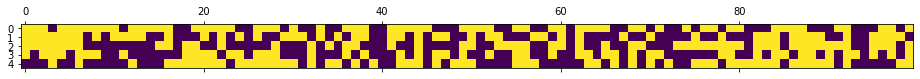

In [8]:
patterns = np.random.choice([-1,1],size=(M,D))
plt.matshow(patterns)

# Vanilla Hopfield Network

In [9]:
class VanillaHN:
    def __init__(self, patterns,theta):
        self.d = patterns.shape[1]
        self.m = patterns.shape[0]

        assert len(theta) == self.d
        self.theta = theta

        # Hebbian learning
        self.W = np.einsum('ij,ik -> jk',patterns,patterns)/(self.d*self.m) - np.eye(self.d)/self.d

        self.state = np.random.choice([-1,1], self.d)
    
    def get_energy(self):
        return -0.5*np.einsum('i,ij,j->',self.state,self.W,self.state) + np.dot(self.state,self.theta)

    def async_update(self,idx=None,):
        if idx == None:
            idx = [np.random.randint(0,self.d)]
        
        if type(idx) == list:
            idx = np.random.choice(idx,len(idx))
        
        old_state = self.state.copy()
        for i in idx:
            if np.dot(self.state, self.W[i,:]) >= self.theta[i]:
                self.state[i] = 1
            else:
                self.state[i] = -1

        if (old_state != self.state).any():
            return True
        else:
            return False
            
    def set_state(self,new_state):
        assert len(new_state) == len(self.state)
        self.state = new_state



# Inversion Hopfield Network

In [10]:
class InversionHN:
    def __init__(self, patterns,theta,gamma=1):
        self.d = patterns.shape[1]
        self.m = patterns.shape[0]
        self.gamma = gamma
        assert len(theta) == self.d
        self.theta = theta

        # Hebbian learning
        self.W = np.einsum('ij,ik -> jk',patterns,patterns)/(self.d*self.m) - np.eye(self.d)/self.d

    @staticmethod
    def construct_A(P,W,gamma):
        d = W.shape[0]
        A = np.zeros((2*d,2*d))
        A[:d,:d] = W - gamma/2.0*np.eye(d)
        A[:d,d:] = P
        A[d:,:d] = P
        return A

    @staticmethod
    def construct_w(x_inc, theta):
        return np.concatenate((theta,x_inc))

    def solve(self,x_inc, P):
        A = self.construct_A(P,self.W,self.gamma)
        w = self.construct_w(x_inc,self.theta)
        #x,_,_,_ = lstsq(A,w,check_finite=False,overwrite_a=True,overwrite_b=True)
        x, _ = cg(A,w,x0 = np.concatenate((x_inc,np.zeros(self.d))))
        return x[:self.d]
        


        

In [11]:
vanilla_network = VanillaHN(patterns,np.zeros(D))
inversion_network = InversionHN(patterns,np.zeros(D))


In [12]:
vanilla_distances = []
for n_known in tqdm(range(1,51)):
    print(n_known, end=" ")
    rep_dist = []
    for rep in range(1000):

        shuffled_idx = [i for i in range(D)]
        random.shuffle(shuffled_idx)
        known_idx = shuffled_idx[:n_known]
        unknown_idx = shuffled_idx[n_known:]
        initial_state = np.random.choice([-1,1], D)
        initial_state[known_idx] = patterns[0][known_idx]
        vanilla_network.set_state(initial_state)
        i = 0
        while vanilla_network.async_update(idx=unknown_idx):
            i+=1
        H = 0.5*np.sum(np.abs(vanilla_network.state - patterns[0]))
        rep_dist.append(H)
    vanilla_distances.append(np.mean(rep_dist))

  0%|          | 0/50 [00:00<?, ?it/s]

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

In [13]:
inversion_distances = []
for n_known in tqdm(range(1,51)):
    print(n_known,end=" ")
    rep_dist = []
    for rep in range(1000):
        shuffled_idx = [i for i in range(D)]
        random.shuffle(shuffled_idx)
        known_idx = shuffled_idx[:n_known]
        unknown_idx = shuffled_idx[n_known:]
        P = np.eye(D)
        P[unknown_idx] = 0
        x_inc = patterns[0].copy()
        x_inc[unknown_idx] = 0
        sol = inversion_network.solve(x_inc,P)
        H = 0.5*np.sum(np.abs(np.sign(sol) - patterns[0]))
        rep_dist.append(H)
    inversion_distances.append(np.mean(rep_dist))

  0%|          | 0/50 [00:00<?, ?it/s]

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

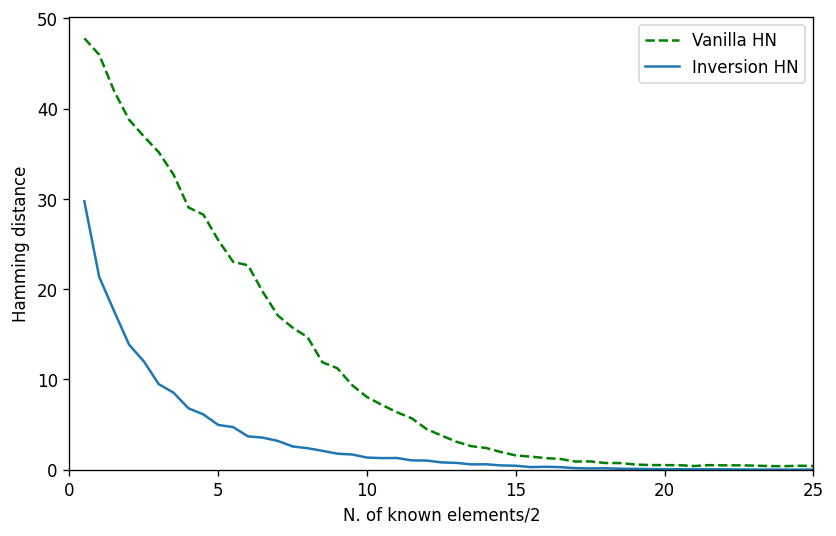

In [14]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 120
plt.plot(0.5*(1+np.arange(50)),vanilla_distances,label="Vanilla HN",linestyle='dashed',c='green')
plt.plot(0.5*(1+np.arange(50)),inversion_distances,label="Inversion HN")

plt.xlabel("N. of known elements/2")
plt.ylabel("Hamming distance")
plt.xlim([0,25])
plt.ylim([0,None])
plt.legend()

# $A$ matrix

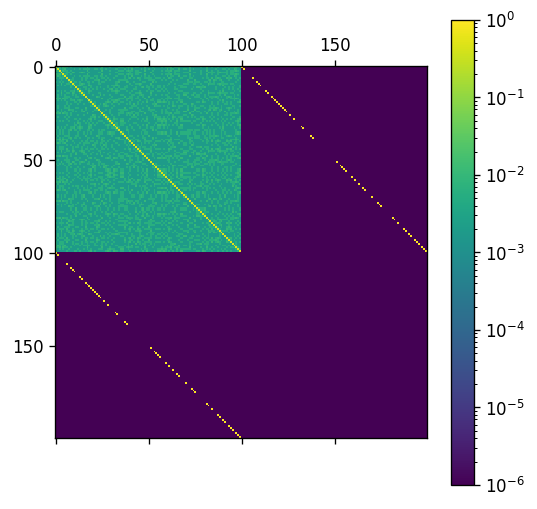

In [15]:
from matplotlib.colors import LogNorm
plt.matshow(np.abs(inversion_network.construct_A(P,inversion_network.W,1))+1e-6,norm=LogNorm(vmin=1E-6,vmax=1))
plt.colorbar()